## Process Flow


1.   Load Datasets
2.   **Pre-process dataset** by removing special characters, stopwords, and other noise, and convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** using **LSTM Model** and analyse model performance and results

## **Setup**

In [1]:
#@title Imports

import spacy
import string
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import RegexpTokenizer # ImportRegexpTokenizer to remove punctuation and tokenize
from nltk.stem import WordNetLemmatizer
from numpy import array
from keras import models
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Embedding, Flatten, Input
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/user/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
#@title GloVe Word Embeddings
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

zsh:1: command not found: wget


In [5]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## **Load Data**

In [2]:
books_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/books/positive.xml")
books_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/books/negative.xml")

dvd_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/dvd/positive.xml")
dvd_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/dvd/negative.xml")

electronics_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/electronics/positive.xml")
electronics_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/electronics/negative.xml")

kitchen_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/kitchen_%26_housewares/positive.xml")
kitchen_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/kitchen_%26_housewares/negative.xml")

## **Quick Data Eval**

In [ ]:
def show_rating_graph(collection, title):
  # Must have a rating column
  ax = collection['rating'].value_counts().sort_index().plot(kind='bar', title=title)
  ax.set_xlabel('Rating')
  plt.show()

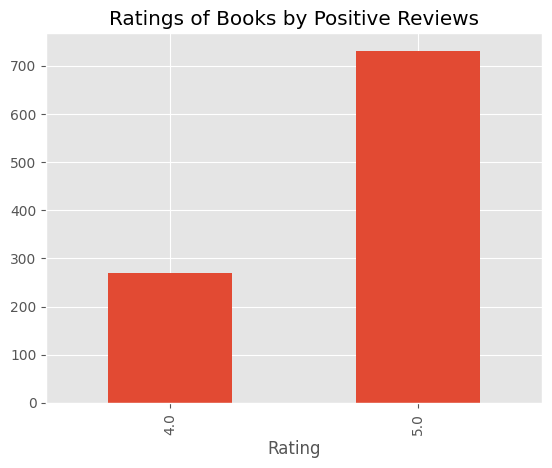

In [ ]:
#@title Books: Positive

show_rating_graph(books_positive, "Ratings of Books by Positive Reviews")

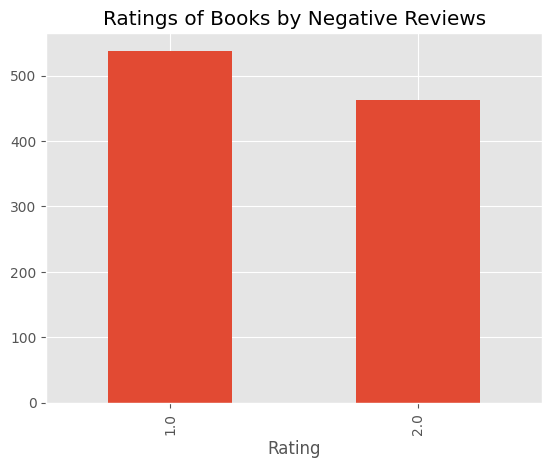

In [ ]:
#@title Books: Negative

show_rating_graph(books_negative, "Ratings of Books by Negative Reviews")

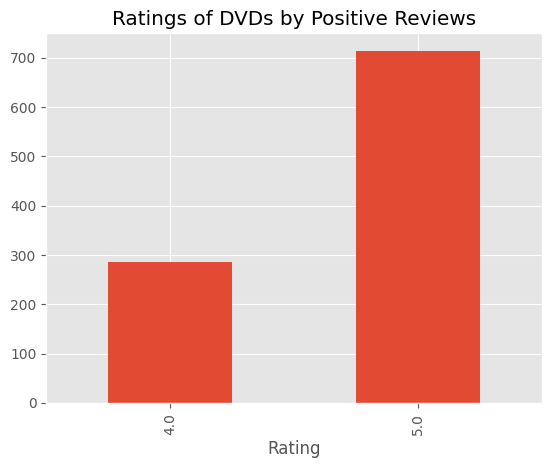

In [ ]:
#@title DVDs: Positive

show_rating_graph(dvd_positive, "Ratings of DVDs by Positive Reviews")

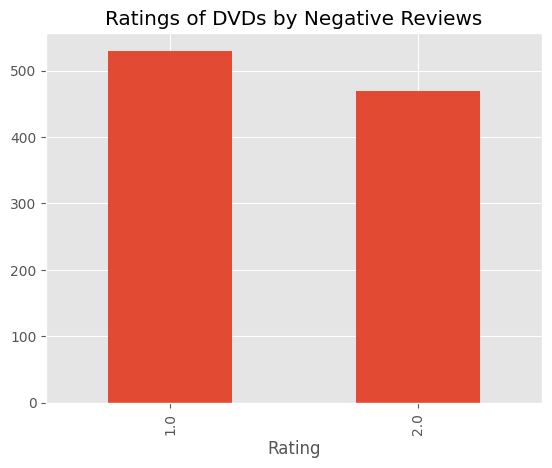

In [ ]:
#@title DVDs: Negative

show_rating_graph(dvd_negative, "Ratings of DVDs by Negative Reviews")

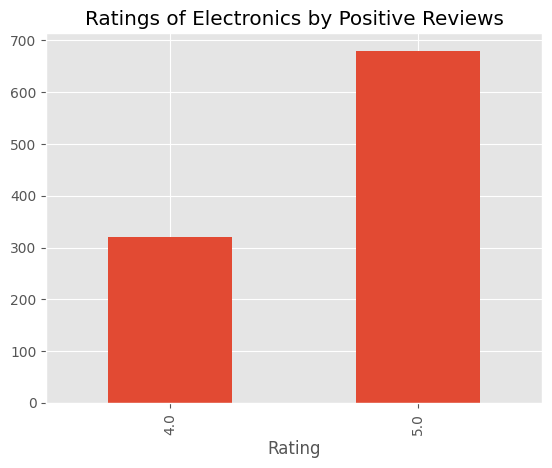

In [ ]:
#@title Electronics: Positive

show_rating_graph(electronics_positive, "Ratings of Electronics by Positive Reviews")

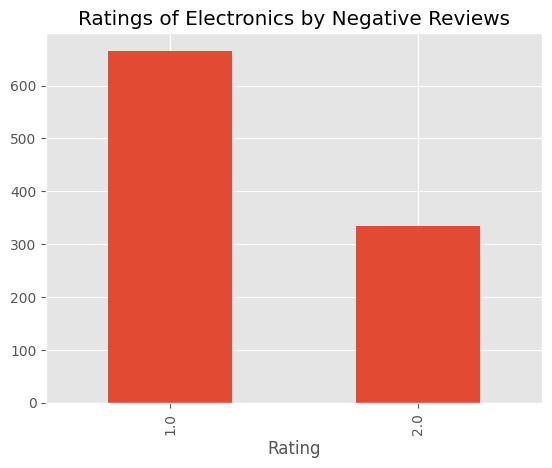

In [ ]:
#@title Electronics: Negative

show_rating_graph(electronics_negative, "Ratings of Electronics by Negative Reviews")

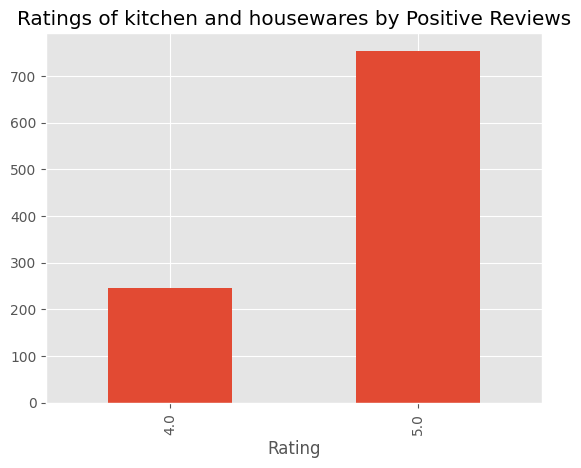

In [ ]:
#@title Kitchen and Housewares: Positive

show_rating_graph(kitchen_positive, "Ratings of kitchen and housewares by Positive Reviews")

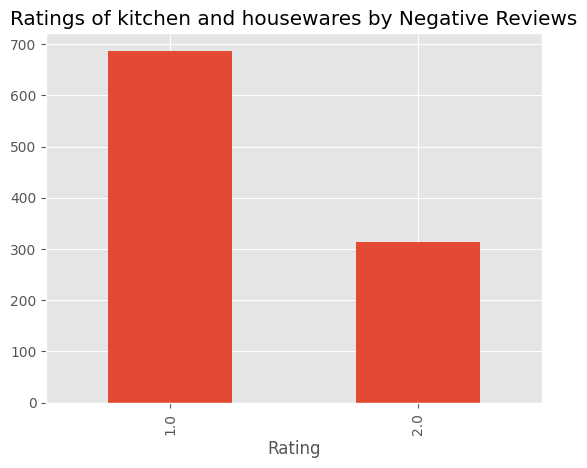

In [ ]:
#@title Kitchen and Housewares: Negative

show_rating_graph(kitchen_negative, "Ratings of kitchen and housewares by Negative Reviews")

# **Training**

## **Step 1: Creating Dictionary for Embeddings**

In [3]:
#@title Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

## **Step 2: Preparing Data**

In [24]:
#@title Cleaning Data Functions

tokenizer = RegexpTokenizer(r'\w+')
nlp = spacy.load("en_core_web_lg")

# Search for the first antonym for a word to handle negations
def antonym_for(word):
  antonyms = set()
  for ss in wn.synsets(word):
    for lemma in ss.lemmas():
      any_pos_antonyms = [ antonym.name() for antonym in lemma.antonyms() ]
      for antonym in any_pos_antonyms:
        antonym_synsets = wn.synsets(antonym)
        if wn.ADJ not in [ ss.pos() for ss in antonym_synsets ]:
          continue
        return antonym

  return antonyms

# Remove punctuations, handle negation and Tokenize
def tokenize_review(input_string):
  doc = nlp(input_string)
  doc_len = len(doc)
  skip_next_word = False
  tokens = []

  for i, token in enumerate(doc):
    if(skip_next_word):
      skip_next_word = False
      continue

    if(token.dep_ == "neg" and i < (doc_len - 1) and doc[i + 1].pos_ == "ADJ" and doc[i + 1].dep_ == "acomp"):
      antonym = antonym_for(doc[i + 1].lemma_)

      if(antonym != set()):
        skip_next_word = True
        tokens.append(antonym_for(doc[i + 1].lemma_))
      else:
        tokens.append(token)
    else:
      tokens.append(token.lemma_)

  return tokens

def message_to_word_vectors(review, word_dict=embeddings_dictionary):
  processed_list_of_tokens = tokenize_review(review)
  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors).astype(float)

def preprocess_reviews(reviews):
  return [message_to_word_vectors(review) for review in reviews]

# # Remove Stopwords
# def remove_stopwords(token_collection):
#   # Get the list of English stopwords
#   english_stopwords = stopwords.words('english')

#   # Remove stopwords
#   return [[word for word in tokens if word.lower() not in english_stopwords] for tokens in token_collection]

In [45]:
#@title Setting up Positive Reviews

positive_reviews = pd.concat([books_positive, dvd_positive, electronics_positive, kitchen_positive])
positive_vectors = preprocess_reviews(positive_reviews['review_text'])
# positive_tokenized_collection = tokenize_reviews(positive_reviews['review_text'])
# positive_filtered_tokens = remove_stopwords(positive_tokenized_collection)

In [46]:
#@title Setting up Negative Reviews

negative_reviews = pd.concat([books_negative, dvd_negative, electronics_negative, kitchen_negative])
negative_vectors = preprocess_reviews(negative_reviews['review_text'])
# positive_tokenized_collection = tokenize_reviews(negative_reviews['review_text'])
# negative_filtered_tokens = remove_stopwords(positive_tokenized_collection)

(array([2.902e+03, 6.800e+02, 2.390e+02, 9.800e+01, 4.300e+01, 1.700e+01,
        1.200e+01, 7.000e+00, 1.000e+00, 1.000e+00]),
 array([1.000e+00, 1.650e+02, 3.290e+02, 4.930e+02, 6.570e+02, 8.210e+02,
        9.850e+02, 1.149e+03, 1.313e+03, 1.477e+03, 1.641e+03]),
 <BarContainer object of 10 artists>)

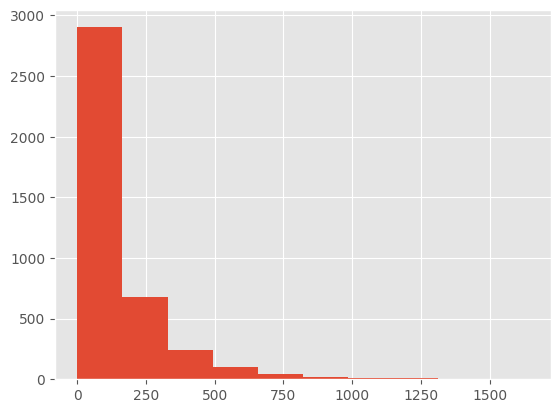

In [47]:
#@title Visualizing Sequence Lengths for Positive Reviews
positive_sequence_lengths = []

for i in range(len(positive_vectors)):
  positive_sequence_lengths.append(len(positive_vectors[i]))

import matplotlib.pyplot as plt

plt.hist(positive_sequence_lengths)

(array([3.732e+03, 2.210e+02, 3.300e+01, 1.000e+01, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.0000e+00, 3.6780e+02, 7.3260e+02, 1.0974e+03, 1.4622e+03,
        1.8270e+03, 2.1918e+03, 2.5566e+03, 2.9214e+03, 3.2862e+03,
        3.6510e+03]),
 <BarContainer object of 10 artists>)

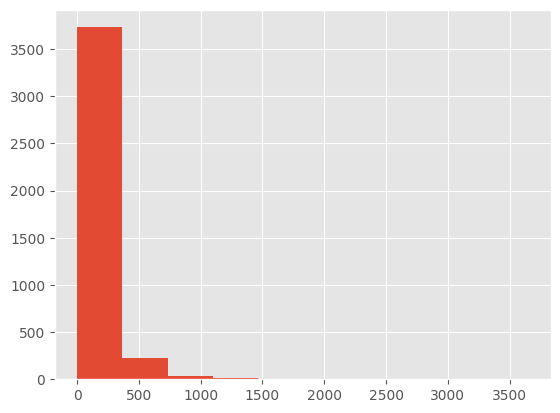

In [48]:
#@title Visualizing Sequence Lengths for Negative Reviews
negative_sequence_lengths = []

for i in range(len(negative_vectors)):
  negative_sequence_lengths.append(len(negative_vectors[i]))

import matplotlib.pyplot as plt

plt.hist(negative_sequence_lengths)

In [49]:
pd.Series(positive_sequence_lengths + negative_sequence_lengths).describe()

count    8000.000000
mean      145.538000
std       163.819965
min         1.000000
25%        53.000000
50%        96.000000
75%       175.000000
max      3651.000000
dtype: float64

## **Step 3: Embedding Data**

In [50]:
#@title Combine positive and negative reviews with labels
reviews = positive_vectors + negative_vectors
labels = np.array([1] * len(positive_vectors) + [0] * len(negative_vectors))

In [51]:
#@title Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [52]:
#@title Padding all reviews

from copy import deepcopy

def pad_X(X, desired_sequence_length=300):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    if sequence_length_difference < 0:
      X_copy[i] = x[:300]
    else:
      pad = np.zeros(shape=(sequence_length_difference, 300))
      X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [53]:
X_train = pad_X(X_train)
X_val = pad_X(X_val)
X_test = pad_X(X_test)

In [54]:
X_train.shape, X_val.shape, X_test.shape

((5600, 300, 300), (1200, 300, 300), (1200, 300, 300))

In [55]:
y_train.shape

(5600,)

In [56]:
X_val.shape, y_val.shape

((1200, 300, 300), (1200,))

In [60]:
frequencies = pd.value_counts(pd.concat([positive_reviews, negative_reviews])['rating'])

frequencies

rating
5.0    2879
1.0    2421
2.0    1579
4.0    1121
Name: count, dtype: int64

In [61]:
weights = {0: frequencies.sum() / (frequencies[2.0] + frequencies[1.0]), 1: frequencies.sum() / (frequencies[5.0] + frequencies[4.0])}
weights

{0: 2.0, 1: 2.0}

## **Step 4: Model Training**

In [62]:
#@title Use Sequential for Neural Network architecture

lstm_model = Sequential()
lstm_model.add(Input(shape=(300, 300)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(Flatten())

lstm_model.add(Dense(1, activation='sigmoid'))

In [63]:
#@title Model compiling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cp = ModelCheckpoint('model/', save_best_only=True)

lstm_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy', AUC(name='auc')])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 300, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 300, 128)          0         
                                                                 
 flatten (Flatten)           (None, 38400)             0

In [64]:
#@title Model Training with 128 batch size and 20 epochs

lstm_model_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, epochs=20, verbose=1, class_weight=weights)

Epoch 1/20
44/44 [==============================] - 87s 2s/step - loss: 1.3734 - accuracy: 0.5545 - auc: 0.5770 - val_loss: 0.6667 - val_accuracy: 0.6492 - val_auc: 0.7068
Epoch 2/20
44/44 [==============================] - 70s 2s/step - loss: 1.2235 - accuracy: 0.6775 - auc: 0.7343 - val_loss: 0.5587 - val_accuracy: 0.7275 - val_auc: 0.7958
Epoch 3/20
44/44 [==============================] - 73s 2s/step - loss: 1.0679 - accuracy: 0.7418 - auc: 0.8132 - val_loss: 0.5353 - val_accuracy: 0.7550 - val_auc: 0.8167
Epoch 4/20
44/44 [==============================] - 73s 2s/step - loss: 1.0316 - accuracy: 0.7611 - auc: 0.8281 - val_loss: 0.5753 - val_accuracy: 0.7142 - val_auc: 0.8228
Epoch 5/20
44/44 [==============================] - 72s 2s/step - loss: 1.0228 - accuracy: 0.7550 - auc: 0.8305 - val_loss: 0.5076 - val_accuracy: 0.7650 - val_auc: 0.8333
Epoch 6/20
44/44 [==============================] - 71s 2s/step - loss: 0.9544 - accuracy: 0.7839 - auc: 0.8561 - val_loss: 0.5048 - val_acc

In [65]:
#@title Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

38/38 [==============================] - 6s 167ms/step - loss: 0.4625 - accuracy: 0.8017 - auc: 0.8759


In [66]:
#@title Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4625321924686432
Test Accuracy: 0.8016666769981384


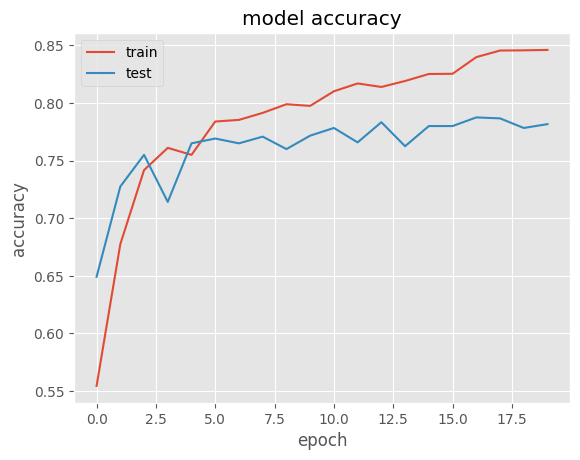

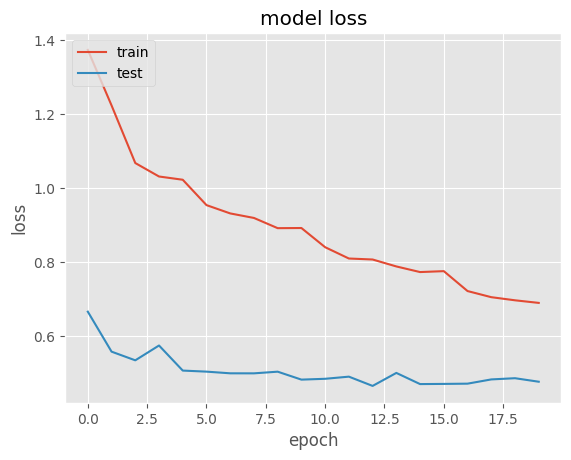

In [67]:
#@title Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [68]:
round(score[1], 3)

0.802

In [69]:
#@title Saving the model as a keras file for possible use later

lstm_model.save("model.keras")

## **Step 5: Test Model**

In [70]:
#@title Load Model
# loaded_model = models.load_model("model.keras")

# List of sample reviews
sample_reviews = [
    "This movie was amazing! I loved every moment of it.",
    "The product arrived damaged and the quality is terrible.",
    "The book was okay, but not as good as I expected.",
    "This restaurant has the best food ever. Highly recommended!",
    "I'm extremely disappointed with this purchase. Waste of money.",
    "I was expecting the movie will be good, but it was actually bad!",
    "I was expecting the car will be horrible, but it was actually good!",
    "Cancelled",
    "it be bad it be good"
]

In [71]:
#@title Tokenize and pad sequences for the sample reviews
untested_vectors = preprocess_reviews(sample_reviews)

print(len(untested_vectors))

9


In [72]:
unseen_padded = pad_X(untested_vectors)
unseen_padded.shape

(9, 300, 300)

In [73]:
#@title Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 690ms/step


array([[0.98697996],
       [0.16448374],
       [0.4668457 ],
       [0.9484596 ],
       [0.0131858 ],
       [0.2954001 ],
       [0.5487612 ],
       [0.4006878 ],
       [0.2600341 ]], dtype=float32)